In [11]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import MobileNetV2, EfficientNetB0, ResNet50V2
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, AlphaDropout, Conv2D, AveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [12]:
# Directorios de los datasets
train_dir = "./datos/train"
val_dir = "./datos/val"
test_dir = "./datos/test"

In [17]:
# Parámetros
img_size = (224, 224)
batch_size = 8
num_classes = 4  # Normal, Pólipos, Úlcera, Esophagitis

datagen_train = ImageDataGenerator(
    rescale=1.0/255,
    #preprocessing_function=preprocess_input,
    rotation_range=45,  # Rotación de hasta 45 grados
    width_shift_range=0.1,  # Desplazamiento horizontal del 10%
    height_shift_range=0.1,  # Desplazamiento vertical del 10%
    shear_range=0.1,  # Transformación de cizallamiento del 10%
    zoom_range=0.1,  # Zoom de hasta un 10%
    horizontal_flip=True,  # Volteo horizontal
    vertical_flip=True,  # Volteo vertical
    fill_mode='constant',  # Relleno con valores constantes
    brightness_range=[0.1, 1.0]  # Ajuste de brillo entre 0.1 y 1.0
)
 #evitamos el sobreajuste
datagen_val_test = ImageDataGenerator(rescale=1.0/255)
#datagen_val_test = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = datagen_train.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    seed=42,
    class_mode='categorical' #salida formato one_hot encoding ya que hay mas de 2 clases
)

val_generator = datagen_val_test.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    seed=42,
    class_mode='categorical', #salida formato one_hot encoding ya que hay mas de 2 clases
    shuffle=False
)

test_generator = datagen_val_test.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    seed=42,
    class_mode='categorical', #salida formato one_hot encoding ya que hay mas de 2 clases
    shuffle=False
)

Found 3200 images belonging to 4 classes.
Found 2000 images belonging to 4 classes.
Found 800 images belonging to 4 classes.


## EfficientNetB0

250/250 [==============================] - 14s 51ms/step

Validation Classification Report (Base Data Augmentation):
                      precision    recall  f1-score   support

            0_normal       0.94      1.00      0.97       500
1_ulcerative_colitis       0.93      0.90      0.91       500
            2_polyps       0.91      0.88      0.90       500
       3_esophagitis       0.99      1.00      1.00       500

            accuracy                           0.94      2000
           macro avg       0.94      0.94      0.94      2000
        weighted avg       0.94      0.94      0.94      2000

AUC (macro, one-vs-rest): 0.9934
250/250 [==============================] - 12s 44ms/step

Validation Classification Report (Data Augmentation Agressive):
                      precision    recall  f1-score   support

            0_normal       0.94      1.00      0.97       500
1_ulcerative_colitis       0.93      0.92      0.93       500
            2_polyps       0.94      0.88 

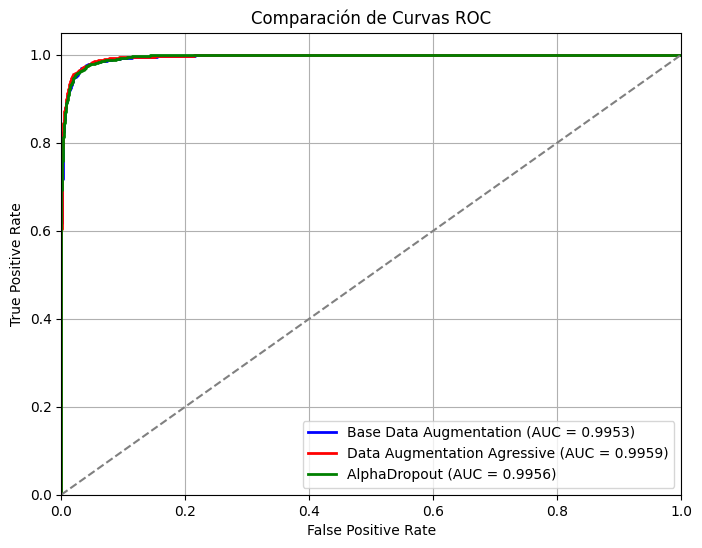

In [15]:
y_true_val = val_generator.classes
y_true_onehot = label_binarize(y_true_val, classes=range(num_classes))
class_names = list(val_generator.class_indices.keys())

def build_efficientnet_model():
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False
    x = base_model.layers[-17].output 
    x = Conv2D(filters=192, kernel_size=1, strides=1, padding='valid',
            activation='selu', kernel_initializer='lecun_normal')(x) 
    x = AveragePooling2D(pool_size=1, strides=1, padding='valid')(x)
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='selu', kernel_initializer='lecun_normal')(x)  
    x = AlphaDropout(0.2)(x) 
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=outputs)
    return model

# Función para evaluar el modelo y obtener métricas
def evaluate_model(weights_path, description):
    model = build_efficientnet_model()
    model.load_weights(weights_path)
    model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

    y_pred_prob = model.predict(val_generator)
    y_pred_val = np.argmax(y_pred_prob, axis=1)

    print(f"\nValidation Classification Report ({description}):")
    print(classification_report(y_true_val, y_pred_val, target_names=class_names))

    auc_score = roc_auc_score(y_true_onehot, y_pred_prob, average='macro', multi_class='ovr')
    print(f"AUC (macro, one-vs-rest): {auc_score:.4f}")

    return y_pred_prob, description

# Evaluar los tres modelos y almacenar resultados
models = {
    "Base Data Augmentation": "./Base_Articulo/efficientnetb0_best_weights.h5",
    "Data Augmentation Agressive": "./Base_DataArgumentation/efficientnetb0_best_weights.h5",
    "AlphaDropout": "./Base_Dropout/efficientnetb0_best_weights.h5"
}

roc_data = []

for description, weights_path in models.items():
    y_pred_prob, desc = evaluate_model(weights_path, description)
    roc_data.append((y_pred_prob, desc))

# Generar gráfico de curva ROC comparativa
plt.figure(figsize=(8, 6))
colors = ["blue", "red", "green"]

for (y_pred_prob, description), color in zip(roc_data, colors):
    fpr, tpr, _ = roc_curve(y_true_onehot.ravel(), y_pred_prob.ravel())
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, lw=2, label=f"{description} (AUC = {roc_auc:.4f})")

plt.plot([0, 1], [0, 1], color="gray", linestyle="--")  # Línea diagonal de referencia
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Comparación de Curvas ROC")
plt.legend(loc="lower right")
plt.grid()
plt.show()


## MobileNetV2

250/250 [==============================] - 11s 43ms/step

Validation Classification Report Base Data Augmentation:
                      precision    recall  f1-score   support

            0_normal       0.99      0.97      0.98       500
1_ulcerative_colitis       0.95      0.95      0.95       500
            2_polyps       0.96      0.97      0.97       500
       3_esophagitis       0.99      1.00      0.99       500

            accuracy                           0.97      2000
           macro avg       0.97      0.97      0.97      2000
        weighted avg       0.97      0.97      0.97      2000

AUC (macro, one-vs-rest): 0.9984
250/250 [==============================] - 11s 42ms/step

Validation Classification Report Data Augmentation Agressive:
                      precision    recall  f1-score   support

            0_normal       0.99      0.96      0.98       500
1_ulcerative_colitis       0.94      0.94      0.94       500
            2_polyps       0.95      0.96     

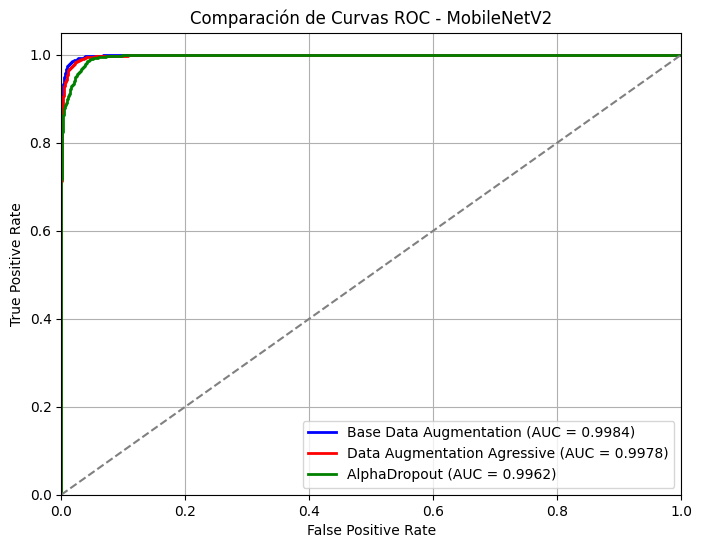

In [18]:
y_true_val = val_generator.classes
n_classes = len(val_generator.class_indices)
y_true_onehot = label_binarize(y_true_val, classes=range(n_classes))

# Definir modelos y sus rutas de pesos
models = {
    "Base Data Augmentation": "./Base_Articulo/mobilenetv2_gastro_model.h5",
    "Data Augmentation Agressive": "./Base_DataArgumentation/mobilenetv2_gastro_model.h5",
    "AlphaDropout": "./Base_Dropout/mobilenetv2_gastro_model.h5"
}

roc_data = []
colors = ["blue", "red", "green"]

# Evaluación y almacenamiento de datos para la curva ROC
for description, model_path in models.items():
    model = keras.models.load_model(model_path)
    y_pred_prob = model.predict(val_generator)
    y_pred_val = np.argmax(y_pred_prob, axis=1)

    print(f"\nValidation Classification Report {description}:")
    print(classification_report(y_true_val, y_pred_val, target_names=val_generator.class_indices.keys()))

    auc_score = roc_auc_score(y_true_onehot, y_pred_prob, average='macro', multi_class='ovr')
    print(f"AUC (macro, one-vs-rest): {auc_score:.4f}")

    roc_data.append((y_pred_prob, description, auc_score))

# Generación de la gráfica ROC comparativa
plt.figure(figsize=(8, 6))

for (y_pred_prob, description, auc_score), color in zip(roc_data, colors):
    fpr, tpr, _ = roc_curve(y_true_onehot.ravel(), y_pred_prob.ravel())
    plt.plot(fpr, tpr, color=color, lw=2, label=f"{description} (AUC = {auc_score:.4f})")

plt.plot([0, 1], [0, 1], color="gray", linestyle="--")  # Línea de referencia
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Comparación de Curvas ROC - MobileNetV2")
plt.legend(loc="lower right")
plt.grid()

# Mostrar la gráfica
plt.show()


## ResNetV2

250/250 [==============================] - 12s 47ms/step

Validation Classification Report Base Data Augmentation:
                      precision    recall  f1-score   support

            0_normal       1.00      0.98      0.99       500
1_ulcerative_colitis       0.89      0.86      0.87       500
            2_polyps       0.87      0.87      0.87       500
       3_esophagitis       0.97      1.00      0.98       500

            accuracy                           0.93      2000
           macro avg       0.93      0.93      0.93      2000
        weighted avg       0.93      0.93      0.93      2000

AUC (macro, one-vs-rest): 0.9901
250/250 [==============================] - 12s 45ms/step

Validation Classification Report Data Augmentation Agressive:
                      precision    recall  f1-score   support

            0_normal       1.00      0.93      0.96       500
1_ulcerative_colitis       0.85      0.83      0.84       500
            2_polyps       0.82      0.86     

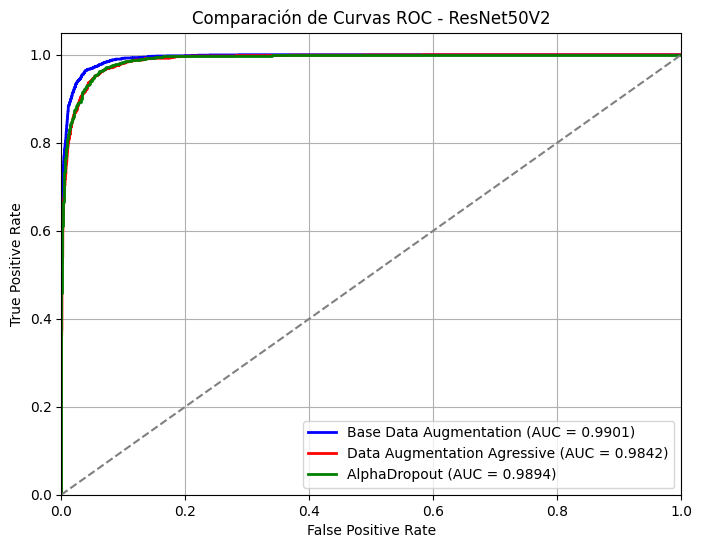

In [20]:
y_true_val = val_generator.classes
n_classes = len(val_generator.class_indices)
y_true_onehot = label_binarize(y_true_val, classes=range(n_classes))

# Definir modelos y sus rutas de pesos
models = {
    "Base Data Augmentation": "./Base_Articulo/resnet50v2_gastro_model.h5",
    "Data Augmentation Agressive": "./Base_DataArgumentation/resnet50v2_gastro_model.h5",
    "AlphaDropout": "./Base_Dropout/resnet50v2_gastro_model.h5"
}

roc_data = []
colors = ["blue", "red", "green"]

# Evaluación y almacenamiento de datos para la curva ROC
for description, model_path in models.items():
    model = keras.models.load_model(model_path)
    y_pred_prob = model.predict(val_generator)
    y_pred_val = np.argmax(y_pred_prob, axis=1)

    print(f"\nValidation Classification Report {description}:")
    print(classification_report(y_true_val, y_pred_val, target_names=val_generator.class_indices.keys()))

    auc_score = roc_auc_score(y_true_onehot, y_pred_prob, average='macro', multi_class='ovr')
    print(f"AUC (macro, one-vs-rest): {auc_score:.4f}")

    roc_data.append((y_pred_prob, description, auc_score))

# Generación de la gráfica ROC comparativa
plt.figure(figsize=(8, 6))

for (y_pred_prob, description, auc_score), color in zip(roc_data, colors):
    fpr, tpr, _ = roc_curve(y_true_onehot.ravel(), y_pred_prob.ravel())
    plt.plot(fpr, tpr, color=color, lw=2, label=f"{description} (AUC = {auc_score:.4f})")

plt.plot([0, 1], [0, 1], color="gray", linestyle="--")  # Línea de referencia
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Comparación de Curvas ROC - ResNet50V2")
plt.legend(loc="lower right")
plt.grid()

# Mostrar la gráfica
plt.show()